In [1]:
!pip install noisereduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
from scipy.fft import fft, fftshift, fftfreq, ifft, ifftshift, dct
import sklearn as sk
import scipy as sc
import scipy.signal as scp
import numpy.random as rnd
from scipy.io import wavfile
from IPython.display import Audio
import noisereduce as nr
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split
from sklearn import tree
import os

In [2]:
# Variables
data_path = "./data/9/"
data_folder = os.getcwd() + "/data"
fs = 48000



In [50]:
# Utility Functions
import librosa
def create_dataset(root):
    """
    Creates a dataset out of all the files 
    """
    data    = []
    labels  = []
    
    for dirpath, dirnames, filenames in os.walk(root):
        for filename in filenames:
            # the first letter in dirpath is the folder and thus the label
            label = dirpath[-1]
            _ , signal   = wavfile.read(f"{dirpath}/{filename}")
            
            # Clean the signal. This is important as MFCC are sensitive to noise
            cleaned  = clean_data(signal)
            
            # Calculate MFCC (and delta and deltadelta)
            # Delta and deltadelta are not used as they had a negative impact on performance
            
            mfcc, delta, deltadelta  = MFCC(cleaned, fs)
            target     = 200
            features   = []
            
            # They remain here as zombies for future experimentation purposes
            #delta = np.append(delta, np.zeros(target - len(delta)))
            #deltadelta = np.append(deltadelta, np.zeros(target - len(deltadelta)))
            #features.extend(delta)
            
            
            # Our feature array is a flattened array of mfcc coefficients
            features.extend(mfcc.flatten())
            
            features[features!=features] = 0
            features  = np.insert(features, 0, len(cleaned))
        
            data.append(features)
            labels.append(label)


            
    df = pd.DataFrame(data, index=labels).sort_index()
    df[df!=df] = 0

    return df

def generate_noisy(data, ratio):
    """
    Generate noisy variant of data.
    noise is additive and normally distributed
    """
    return data + rnd.normal(0,1,len(data)) * max(abs(data)) * ratio

def clean_data(data):
    """
    remove silent spaces and noise
    """
    # Here we use the denoising function made in some earlier assignment
    wlen = int(0.03*fs)
    hop  = int(wlen/2) 
        
    f, t, X = stft(x=data,
               fs=fs,
               nperseg=wlen,
               noverlap=hop,
               return_onesided=True)

    PSD = abs(X)**2
    
    coef = 10
    mean = coef*10**(1/10*np.mean(10*np.log10(PSD),1))
    
    PSDN_est = np.ones(PSD.shape)*mean[:,None]
    g = (PSD-PSDN_est)/PSD
    
    g[g<0] = 10**(-32)
    g = np.sqrt(g)
    S = X*g
    t_p, processed = istft(S, fs=fs, nperseg=wlen, noverlap=hop)
    
    # And finally, trim silence from each end of the signal
    trimmed, _ = librosa.effects.trim(processed, top_db=25)

    return trimmed
    
def read_wav(path):
    """
    Reads wav file
    Returns time and signal vectors
    """
    fs, signal = wavfile.read(path)
    t = np.arange(0,len(signal)/fs, 1/fs)
    return [t, signal]

def remove_noise(data):
    """
    Simple function to remove the noise from the signal data
    """
    return nr.reduce_noise(y=data, sr=fs)

def predict_input(audioname, model, scaler, length):
    _, test_sample = wavfile.read(f"./predict/{audioname}.wav")
    clean = clean_data(test_sample)
    features,_,_ = MFCC(clean, fs)
    features[features!=features] = 0
    features = np.insert(features, 0, len(clean))
    features = np.pad(features, (0, length-len(features)))
    features = np.tile(features, (10,1))
    features = scaler.transform(features)

    pred = model.predict(X=features)
    vals, counts = np.unique(pred, return_counts = True)
    return vals[0]
        

In [51]:
# Feature extraction functions
# http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

def mel(f):
    """
    Transform to mel space
    """ 
    return 1127*np.log(1+f/700)

def imel(m):
    """
    Transform from mel space to frequency domain
    """
    return 700*(np.exp(m/1127) - 1)

def MFCC(signal, fs):
    np.seterr(divide='ignore')
    """
    Compute mel frequency coefficients
    """
    # compute spectrum for frames of 25 ms with 10 ms overlaps
    Nfft = 2048
    f, t, Z = stft(x=signal, fs=fs, window='hann', nperseg=fs*25e-3, noverlap=fs*10e-3, nfft=Nfft)
    Nf = len(t) # number of frames in signal
    Ncut = int(np.ceil(Nfft/6)) # 342 point spectrum
    # turn each FFT window into power spectrum by scaling
    P = np.zeros((Nf,Ncut))
    for n in range(Nf):
        Fcut = Z[:Ncut,n] # compute the 342 point power spectrum
        P[n] = abs(Fcut)**2/Ncut
    
    # upper and lower frequency bounds in Hz converted to Mel scale
    upperHz = 8000
    lowerHz = 300
    upperMel = mel(upperHz)
    lowerMel = mel(lowerHz)
    m = np.linspace(lowerMel,upperMel,28) # mel filterbank
    h = imel(m) # filterbank in frequency domain
    f = np.floor((Nfft+1)*h/fs) # filterbank as FFT bin indices
    f = f.astype(int)
    
    # construct filters in filterbank
    mfilters = np.zeros((26,342))
    for n in range(26):
        for i in range(len(f)):
            if i != 0 and i != len(f)-1:
                for iless in range(f[i]-f[i-1]):
                    mfilters[n,f[i-1]+iless] = iless/(f[i]-f[i-1])
                for imore in range(f[i+1]-f[i]):
                    mfilters[n,f[i]+imore] = 1-imore/(f[i+1]-f[i])
    
    M = np.zeros((Nf,26))
    # filter data with filterbank
    for n in range(Nf):
        for c in range(26):
            M[n,c] = sum(mfilters[c]*P[n])
    
    # take the log discrete cosine transform of frame spectra
    mfcc = np.zeros((Nf,12))
    for n in range(Nf):
        mfcc[n] = dct(np.log(M[n]), type=3)[1:13]
    
    # compute mfcc delta functions of first and second degree
    delta = np.zeros((Nf,12))
    deltadelta = np.zeros((Nf,12))
    for n in range(Nf-1):
        delta[n+1] = mfcc[n+1] - mfcc[n]
        deltadelta[n+1] = delta[n+1] - delta[n]
    
    # return ndarray with rows representing timeframes and columns representing the 12 coefficients
    # (or change in coefficients)
    return mfcc, delta, deltadelta


In [ ]:
"""
Generate dataset for training the model
"""

dataset = create_dataset(data_folder)

/tmp/ipykernel_5669/2486714241.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _ , signal   = wavfile.read(f"{dirpath}/{filename}")


In [ ]:
from sklearn.preprocessing     import LabelEncoder, MinMaxScaler
from sklearn.ensemble          import ExtraTreesClassifier
from sklearn.model_selection   import cross_val_score
from sklearn.metrics           import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline          import Pipeline

random_state = 42

# Use MinMaxScaler to scale data between 0 and 1
scaler = MinMaxScaler()

# Select K best features
feature_selection = SelectKBest(chi2, k=450)

# Split data into labels y and features X, here y corresponds to numbers 1 to 9
# and X represents the feature vector described in function "create_dataset()"

X = dataset.values
y = dataset.index

# Split the data into training and testing sets.
# In this case, 33% of the data is allocated as testing data.

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=random_state)



# We chose to use the ExtraTreesClassifier. It has good support for unbalanced datasets.
# Most importantly, it seemed to provide the best performance vs others ( GaussianNB, RandomForest, Knearest and MLP)

model =  ExtraTreesClassifier(n_estimators=480,
                                max_features = "sqrt",
                                criterion    = "entropy",
                                class_weight = "balanced",
                                random_state = random_state)



# Create classification pipeline, this makes sure that all the steps are applied correctly and in the correct order.

pipe = Pipeline(
    [('Scaler', scaler),
     ('Feature selection', feature_selection),
     ('Classifier', model)])




64.0 % mean cross validation score with std  5.5 %


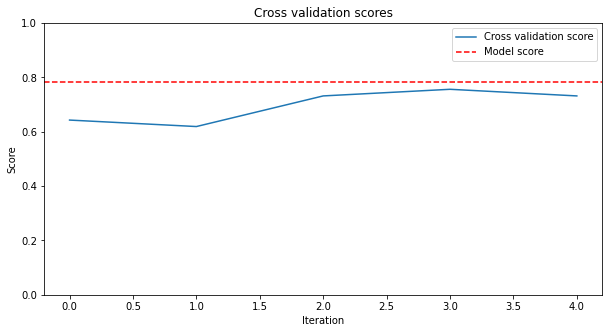

In [49]:
# Calculate 5 fold crossvalidation scores for the model, these represent the models generalization capability

scores = cross_val_score(pipe, X, y, cv=5)

# Fit the pipe to our training data

pipe.fit(X_train, y_train)

# And predict
y_pred = pipe.predict(X_test)
     
cm   = confusion_matrix(y_test, y_pred, labels=labels)
cms += cm
clrs.append(classification_report(y_test, y_pred, target_names=labels))

print(round(scores[0],2)*100,"% mean cross validation score with std ", round(scores.std(),3)*100, "%")


# Plot the cross validation (CV) scores and the model score
# Here we can see that the CV scores are significantly lower that the model score

plt.subplots(figsize = (10,5))
plt.plot(scores)
plt.title("Cross validation scores")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.ylim(0,1)
plt.axhline(curr_score, linestyle = "--", c="r")

curr_score = pipe.score(X_test, y_test)

plt.legend(["Cross validation score", "Model score"])
plt.show()

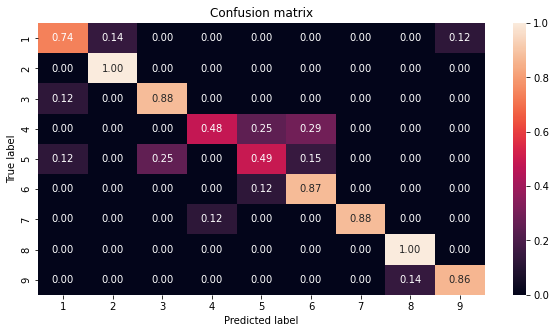

In [39]:
import seaborn as sns

"""

    TP = True positive   FP = False positive
    TF = True negative   FN = False negative

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1-score = (2*recall*precision)/(recall+precision)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
"""
# Normalize confusion matrix
cms = cms / cms.sum(axis=1)


# Display performance using the confusion matrix.
plt.subplots(figsize=(10,5))
sns.heatmap(cms, annot=True,
           fmt=".2f",
           xticklabels = labels,
           yticklabels = labels)

plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
#plt.savefig("CM", dpi = 1200)


In [ ]:
# This sample is from someone whose voice was used to train the model
filename = "viisi_t"
audio_sample = read_wav(f"./predict/{filename}.wav")

prediction = predict_input(filename,model,scaler, X_train.shape[1])
print(f"The number you said was {prediction}")

Audio(audio_sample, rate=fs)

The number you said was 9


/tmp/ipykernel_5669/191364915.py:82: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(path)
/tmp/ipykernel_5669/191364915.py:93: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, test_sample = wavfile.read(f"./predict/{audioname}.wav")


In [8]:
# This sample is from someone whose voice was used to train the model

filename = "test7"
audio_sample = read_wav(f"./predict/{filename}.wav")

prediction = predict_input(filename,model,scaler, X_train.shape[1])
print(f"The number you said was {prediction}")

Audio(audio_sample, rate=fs)

ERROR! Session/line number was not unique in database. History logging moved to new session 21


ValueError: index can't contain negative values

In [ ]:
# This sample is from someone whose voice was used to train the model

filename = "kolme_t"
audio_sample = read_wav(f"./predict/{filename}.wav")

prediction = predict_input(filename,model,scaler, X_train.shape[1])
print(f"The number you said was {prediction}")

Audio(audio_sample, rate=fs)